In [160]:
import HelperFuncs as hfuncs
import numpy as np

We're going to first try training a CNN on the individual images.
We will be using binary cross entropy across the 17 regions.

In [161]:
import HelperFuncs as hfuncs
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import Sequence
import h5py
import os

BATCH_SIZE = 1
FINAL_WIDTH = 400
FINAL_HEIGHT = 600
CHANNELS = 1
ZONES = 17
ANGLES = 16
#Create directories for sequencer function if they don't exist
for d in ['temp/train_scan/','temp/test_scan/','temp/val_scan/']:
    if not os.path.isdir(d):
        print("Created directory: {}".format(d))
        os.makedirs(d)
        
class ScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan"):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((BATCH_SIZE,ANGLES,FINAL_WIDTH,FINAL_HEIGHT,CHANNELS))
        y_train = np.zeros((BATCH_SIZE,ZONES))
        
        j=0
        for i in range(idx*BATCH_SIZE,(idx+1)*BATCH_SIZE):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:,:]
                y_train[j,:] = f['/labels'].value
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train
class LegScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan"):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((BATCH_SIZE,ANGLES,FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))
        y_train = np.zeros((BATCH_SIZE,1))
        
        j=0
        for i in range(idx*BATCH_SIZE,(idx+1)*BATCH_SIZE):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:FINAL_HEIGHT//2,:]
                r_leg = [12,14]
                l_leg = [13,15]
                r_y = np.amax(f['/labels'].value[r_leg])
                #l_y = np.amax(f['/labels'].value[l_leg])
                y_train[j,:] = r_y
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train



In [162]:
from twilio.rest import Client
import configparser
from keras.callbacks import Callback

class SMSNotifier(Callback):
    def on_epoch_end(self,epoch,logs=None):
        #Execute every other epoch
        if epoch % 2 == 0:
            #Get config credentials
            config = configparser.ConfigParser()
            config.read('twilio.conf')
            account_sid = config['DEFAULT']['AccountID']
            auth_token = config['DEFAULT']['AuthToken']
            #Get client
            client = Client(account_sid, auth_token)
            #Create message
            if logs is not None:
                message = "Epoch {} complete. Loss: {} Val_loss: {} ".format(epoch,
                                                                             logs.get('loss'),
                                                                             logs.get('val_loss'))
            else:
                message = "Epoch {} complete. No loss data available.".format(epoch)
            #Sendmessage
            message = client.messages.create(
                to="+16178884129", 
                from_="+18572142288",
                body=message)
        else:
            pass

In [174]:
from keras import backend as K
import tensorflow as tf


def weighted_binary_crossentropy(y_true, y_pred):
    x = 0.18 #Approximate percentage of positives in each of the 17 zones
    POS_ADJ = 0.5/x
    NEG_ADJ = 0.5/(1-x)
    n_values = BATCH_SIZE
    elems = (tf.unstack(y_true,num=n_values,axis=0)) 
    adj = tf.map_fn(lambda x:tuple([tf.cond(tf.equal(x[i],1.),lambda:POS_ADJ,lambda: NEG_ADJ) for i in range(n_values)]),
                    elems, 
                    dtype = tuple([tf.float32 for i in range(n_values)]) )
    adj = tf.stack(adj,axis=0)
    return K.mean(tf.multiply(adj,K.binary_crossentropy(y_true,y_pred)),axis=-1)

In [167]:
#Build pre-trained V2 model
import numpy as np
from keras.layers import Input,Flatten,Dense,Concatenate,Dropout,concatenate,GlobalMaxPool2D
from keras.models import Model
from datetime import datetime
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.metrics import binary_accuracy
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.losses import binary_crossentropy
from keras.applications.inception_v3 import InceptionV3
from keras.layers.core import Lambda
import tensorflow as tf

def ToRGB(x):
    max_v = tf.reduce_max(x)
    min_v = tf.reduce_min(x)
    max_rgb = tf.constant(255,dtype=x.dtype)
    x = tf.floordiv(tf.multiply(tf.subtract(x,min_v),max_rgb),tf.subtract(max_v,min_v))
    return x
def ToGreyScale(x):
    #Divide RGB into 3
    scalar = tf.constant(3,dtype=x.dtype)
    x = tf.floordiv(x,scalar)
    shape = x.get_shape()
    #assume channel_last
    mult = [[1 for d in shape[:-1]],[3]]
    mult = [val for sublist in mult for val in sublist]
    return tf.tile(x,mult)
def ToNewShape(x):
    ndim = len(x.shape)
    if ndim == 5:
        return tf.reverse(tf.transpose(x,[0,1,3,2,4]),[-3])
    elif ndim == 4:
        return tf.reverse(tf.transpose(x,[0,2,1,3]),[-3])
    else:
        raise ValueError("Unexpected number of dims!")

def getSingleLegModel(lstm_dim=5):
    #Single model image
    input_img = Input(shape=(FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))
    
    #preprocess and extract channels
    input_img_pp = Lambda(ToRGB)(input_img)
    input_img_pp = Lambda(ToGreyScale)(input_img_pp)
    input_img_pp = Lambda(resv2.preprocess_input)(input_img_pp)
    input_img_pp = Lambda(ToNewShape)(input_img_pp)
    
    #Load resnet
    incep = InceptionV3(include_top=False,
                          weights='imagenet',
                          input_tensor=None,
                          input_shape=(FINAL_HEIGHT//2,FINAL_WIDTH,3),
                          pooling='max')
    for l in incep.layers:
        l.trainable=False

    #Take off top
    reduced_net = Model(incep.input,[incep.get_layer('mixed1').output,
                                    incep.get_layer('mixed3').output])
    output = reduced_net(input_img_pp)
    out_reduced = []
    for out in output:
        out_reduced.append(GlobalMaxPool2D()(out))
    mixed_layers = Concatenate()(out_reduced)
    print("Max pool output {}".format(mixed_layers.shape))
    intermediate_model = Model(input_img,mixed_layers)
    
    #Time distributed model
    input_scan = Input(shape=(ANGLES,FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))  
    sequenced_model = TimeDistributed(intermediate_model)(input_scan)
  
    #One lstm layer for now
    lstm = LSTM(lstm_dim,recurrent_dropout=0.20)(sequenced_model)
    
    #Finally, 1 dense layers
    out = Dense(1,activation='sigmoid')(lstm)
    #complete model
    try:
        return Model(input_scan, out)
    finally:
        del intermediate_model,sequenced_model,incep
        



In [147]:
incep = InceptionV3(include_top=False,
                          weights=None,
                          input_tensor=None,
                          input_shape=(FINAL_HEIGHT//2,FINAL_WIDTH,3),
                          pooling='max')
for i in range(11):
    print('mixed{}'.format(i),incep.get_layer('mixed{}'.format(i)).output_shape[-3:]," {}".format(np.prod(incep.get_layer('mixed{}'.format(i)).output_shape[-3:])))

mixed0 (35, 47, 256)  421120
mixed1 (35, 47, 288)  473760
mixed2 (35, 47, 288)  473760
mixed3 (17, 23, 768)  300288
mixed4 (17, 23, 768)  300288
mixed5 (17, 23, 768)  300288
mixed6 (17, 23, 768)  300288
mixed7 (17, 23, 768)  300288
mixed8 (8, 11, 1280)  112640
mixed9 (8, 11, 2048)  180224
mixed10 (8, 11, 2048)  180224


In [148]:
from matplotlib import pyplot as plt
%matplotlib inline
#Generators and fit
print("Initializing generators...")
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)

for X, y in train_seq:
    if np.amax(y) == 1:
        break
        


#slm = getSingleLegModel()


Initializing generators...


KeyboardInterrupt: 

Actual y:
[[ 1.]]


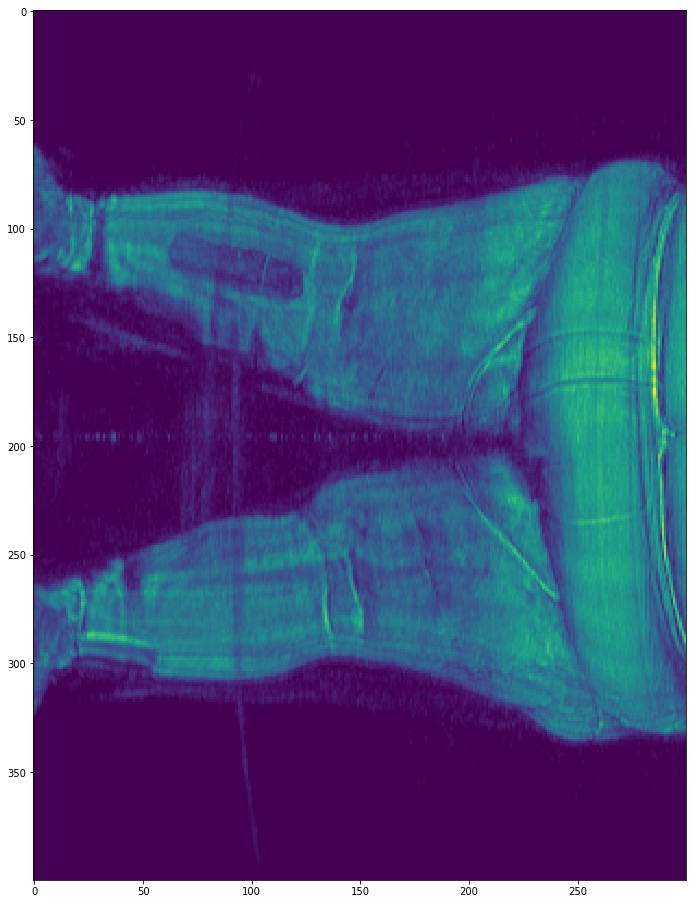

In [130]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
ax.imshow(X[0,0,:,:,0], cmap = 'viridis')

print("Actual y:")
print(y)

In [56]:
sess = tf.InteractiveSession()
z = weighted_binary_crossentropy(tf.convert_to_tensor(y,dtype=tf.float32),tf.convert_to_tensor([[0.]],dtype=tf.float32))
print(z.eval())
print("Expected:{}".format(-0.5/0.1*1*np.log(0.5)))

[ 3.46573591]
Expected:3.4657359027997265


In [133]:
#Test modelchanges
sess = tf.InteractiveSession()
slm = getSingleLegModel()
result = slm.predict(X)

print(result.shape)



(1, 16, 300, 400, 3)


In [ ]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
ax.imshow(result[0,5,:,:,:])#, cmap = 'viridis')


In [157]:
#Test how many positive samples
import pickle
labels = hfuncs.GetLabelsDict(r'stage1_labels.csv')
filename = "data_separated.pickle"
with open(filename,"rb") as f:
   save = pickle.load(f)
   K_test= save['K_test']
   K_val = save['K_val']
   K_train = save['K_train']
s = 0
pos = 0
for k in K_train:
    k_clean = k.replace("DHSData/","").replace(".a3daps","")
    if k_clean in labels.keys():
        label = np.array(labels[k_clean])
        val = np.amax(label[[12,14]])
        if val == 1:
            s += 1
            pos += 1
        else:
            s += 1
print("total={},pos={}".format(s,pos))

total=687,pos=126


In [168]:
from keras.models import load_model
lstm_dim = 20
recurrent_model = getSingleLegModel(lstm_dim)
for l in  recurrent_model.layers:
    print(l.trainable)
#recurrent_model = load_model('check_points/2017_9_26_21_ScanModel_00-0.70.hdf5')

Max pool output (?, 1056)
False
True
True
True


In [ ]:
#optimizer
lr = 0.01
beta1 = 0.9
beta2 = 0.999
description = "Pretrained model"
print("Compiling model...")
adam = Adam(lr,beta_1=beta1,beta_2=beta2)
recurrent_model.compile(optimizer=adam,
                          metrics=[binary_accuracy,binary_crossentropy],
                         loss= weighted_binary_crossentropy)

#Tensorboard
x = datetime.today()
stamp = "{}-{}-{}_{}:{}:{}_lr-{}_beta1-{}_beta2-{}_lstmDim-{}_ANG-{}_{}".format(x.year,x.month,
                                                     x.day,x.hour,x.minute,
                                                     x.second,lr,beta1,beta2,lstm_dim,ANGLES,description)
tensorboard = TensorBoard(log_dir="logs/{}".format(stamp),histogram_freq=0,batch_size=BATCH_SIZE,
                          write_grads=False,write_images=False)
#Model checkpoint
check_point_dir = 'check_points/'
if not os.path.isdir(check_point_dir):
    os.makedirs(check_point_dir)    
chkpt = ModelCheckpoint(os.path.join(check_point_dir,"{}_{}_{}_{}_".format(x.year,x.month,x.day,x.hour) + "ScanModel_{epoch:02d}-{val_loss:.2f}.hdf5"),
                       monitor='val_binary_crossentropy',
                       verbose=1,
                       save_best_only=True)
#Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_binary_crossentropy',
                             factor=0.2,
                             patience=1,
                             verbose=1,
                             min_lr=0.0001,
                             cooldown = 4)
#Notifications
notify = SMSNotifier()

#Early stopping callback
estop = EarlyStopping(monitor='val_binary_crossentropy',min_delta=0.0001,patience=5)

#Generators and fit
print("Initializing generators...")
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)
#Initialize validation sequencer
mode = "val_scan"
num_batches_val = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
val_seq = LegScanSequencer(num_batches_val,UPLOAD_BUCKET,mode=mode)



print("Beginning training...")

hist,model = recurrent_model.fit_generator(train_seq,
                                   steps_per_epoch=num_batches_train,
                                   #steps_per_epoch=5,
                                   epochs=100,
                                   validation_data = val_seq,
                                   validation_steps = num_batches_val,
                                   #validation_steps = 5,
                                   callbacks=[tensorboard,chkpt,reduce_lr,notify,estop],
                                  use_multiprocessing = True,workers=2)


Compiling model...
Initializing generators...
Beginning training...
Epoch 1/100
435/891 [=============>................] - ETA: 1332s - loss: 0.6992 - binary_accuracy: 0.5655 - binary_crossentropy: 0.6613